<center>
    <h1>進階 Python</h1>
    <h3>用 Python 簡單打造一個屬於自己的投資分析 App</h3>
    <h3>Part III - App 實戰</h3>
</center>

這部分沒有目錄，我們將一步一步地帶同學走過，並且用一個叫做 `streamlit` 的套件，來完成最後的 App。由於 Streamlit 目前仍屬於較新的專案，網路上討論的人數較少，但因為也相對較為簡單，所以就帶大家用這個套件囉。

有關於 Streamlit 套件，有興趣的同學也可以到[官網](https://streamlit.io)看看。

In [3]:
from bs4 import BeautifulSoup
import time
from datetime import datetime
import requests 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pws

# 在 Jupyter Notebook 中，只要有加上下面這行，就可以直接在裡面畫圖
%matplotlib inline

# 新的套件
# import streamlit as st
from dateutil.relativedelta import relativedelta # 日期上的運算

## 內容呈現

In [2]:
symbol = '0050.TW'
stock_obj = yf.Ticker(symbol)

# 印出我們的標題

print(f'分析 {stock_obj.info["longName"]}')

分析 Yuanta/P-shares Taiwan Top 50 ETF


In [25]:
tsmc = yf.Ticker('2330.TW')
tsmc.info['dividendRate'] / 100

0.11

In [4]:
current_price = pws.get_price(symbol)
year, div_yield, total_div = pws.get_dividend_yield(symbol)

print(f'參考時價：{current_price}｜殖利率：{div_yield * 100}%')

參考時價：142.65｜殖利率：2.2432527164388363%


股市回測線：


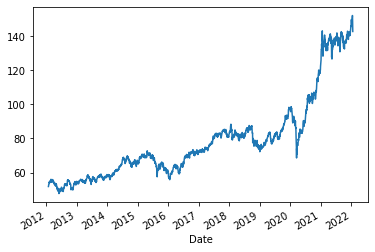

股市歷史走勢圖：


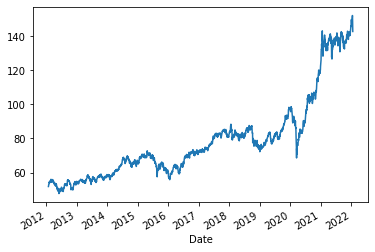

In [7]:
stock_df = stock_obj.history(
    start='2012-1-22', end='2022-1-22', auto_adjust=False)  # period="max"

print('股市回測線：')
stock_df['Adj Close'].plot.line()
plt.show()

print('股市歷史走勢圖：')
stock_df['Close'].plot.line()
plt.show()

年度報酬率：


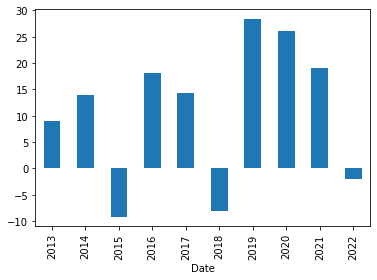

In [8]:
stock_monthly_returns = stock_df['Adj Close'].resample('M').ffill().pct_change() * 100
stock_yearly_returns = stock_df['Adj Close'].resample('Y').ffill().pct_change() * 100

stock_yearly_returns.index = stock_yearly_returns.index.strftime('%Y') #將 index 的 dateformat 改成‘年’
print('年度報酬率：')
stock_yearly_returns.dropna().plot(kind='bar')
plt.show()

beautify_syr = stock_yearly_returns.reset_index().dropna().rename(columns={'Adj Close': 'Percentage Change'})

stock_daily_return = stock_df['Adj Close'].ffill().pct_change()

start = stock_daily_return.index[0]
end = stock_daily_return.index[-1]  # 以 stock 的最後一天為結束日期.

In [10]:
# 假設一開始我們有 3000 元

year_difference = relativedelta(end, start).years + \
    (relativedelta(end, start).months)/12 + \
    (relativedelta(end, start).days)/365.2425

year_difference
init_balance = balance = 3000
total_balance = stock_daily_return.copy()
total_balance[0] = 0

for i in range(len(stock_daily_return)):
    balance = balance * (1+total_balance[i])
    total_balance[i] = balance

total_balance.rename('成長變化', inplace=True)

return_rate = (total_balance[-1] - total_balance[0])/total_balance[0]

cgar = (((1+return_rate)**(1/year_difference))-1)

# **

print(f'經過 {year_difference} 年後，變成 {total_balance[-1]} 元｜年化報酬率為 {cgar * 100}%')


# 股票基本資料
stock_info = stock_obj.info

經過 9.976900620820413 年後，變成 8261.582779778795 元｜年化報酬率為 10.686857999097521%


## 打包！

我們此時可以將上面所寫的程式碼打包成一個函式，方便之後 App 的進行。

In [11]:
def app(stock_id='0050.TW'):
    # stock_id = stock_id
    stock_obj = yf.Ticker(stock_id)

    # 印出我們的標題

    print(f'分析 {stock_obj.info["longName"]}')

    current_price = pws.get_price(stock_id)
    year, div_yield, total_div = pws.get_dividend_yield(stock_id)

    print(f'參考時價：{current_price}｜殖利率：{div_yield * 100}%')

    stock_df = stock_obj.history(
        start='2011-3-12', end='2021-3-12', auto_adjust=False)  # period="max"

    ock_df = stock_obj.history(
        start='2011-3-12', end='2021-3-12', auto_adjust=False)  # period="max"

    print('股市回測線：')
    stock_df['Adj Close'].plot.line()
    plt.show()

    stock_monthly_returns = stock_df['Adj Close'].resample('M').ffill().pct_change() * 100
    stock_yearly_returns = stock_df['Adj Close'].resample('Y').ffill().pct_change() * 100

    stock_yearly_returns.index = stock_yearly_returns.index.strftime('%Y') #將 index 的 dateformat 改成‘年’
    print('年度報酬率：')
    stock_yearly_returns.dropna().plot(kind='bar')
    plt.show()

    stock_daily_return = stock_df['Adj Close'].ffill().pct_change()

    start = stock_daily_return.index[0]
    end = stock_daily_return.index[-1]  # 以 stock 的最後一天為結束日期.

    year_difference = relativedelta(end, start).years + \
        (relativedelta(end, start).months)/12 + \
        (relativedelta(end, start).days)/365.2425

    # 假設一開始我們有 3000 元

    init_balance = balance = 3000
    total_balance = stock_daily_return.copy()
    total_balance[0] = 0

    for i in range(len(stock_daily_return)):
        balance = balance * (1+total_balance[i])
        total_balance[i] = balance

    total_balance.rename('成長變化', inplace=True)

    return_rate = (total_balance[-1] - total_balance[0])/total_balance[0]

    cgar = (((1+return_rate)**(1/year_difference))-1)

    print(f'經過 {year_difference} 年後，變成 {total_balance[-1]} 元｜年化報酬率為 {cgar * 100}%')


    # 股票基本資料
    stock_info = stock_obj.info

實際跑一次看看：

 2330.TW


分析 Taiwan Semiconductor Manufacturing Company Limited
參考時價：641｜殖利率：0.4290171606864275%
股市回測線：


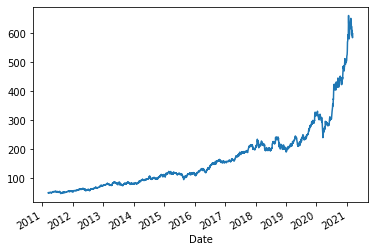

年度報酬率：


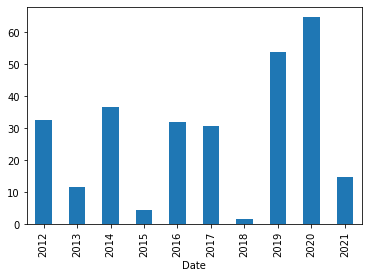

經過 9.98511434184138 年後，變成 36595.963145713584 元｜年化報酬率為 28.467460265224553%


In [13]:
stock_id = input()
app(stock_id)

現在讓我們看看 Streamlit 如何實作吧！